# Table of Contents
 <p>

In [1]:
from pycbc.waveform import td_approximants, get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc import conversions

import numpy
import pylab

In [49]:
def compute_match(q_list, approx1="IMRPhenomD", approx2="SEOBNRv4", f_low=10, sample_rate=4096, mtotal=100):

    matchVals = []

    for n, q in enumerate(q_list):
#         print (n)
        m1 = conversions.mass1_from_mtotal_q(mtotal, q)
        m2 = conversions.mass2_from_mtotal_q(mtotal, q)

        hp, hc = get_td_waveform(approximant=approx1,
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=f_low,
                                 delta_t=1.0/sample_rate)

        sp, sc = get_td_waveform(approximant=approx2,
                                 mass1=m1,
                                 mass2=m2,
                                 f_lower=f_low,
                                 delta_t=1.0/sample_rate)



        # Resize the waveforms to the same length
        tlen = max(len(sp), len(hp))
        sp.resize(tlen)
        hp.resize(tlen)

        # Generate the aLIGO ZDHP PSD
        delta_f = 1.0 / sp.duration
        flen = tlen/2 + 1
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

        # Note: This takes a while the first time as an FFT plan is generated
        # subsequent calls are much faster.
        m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
        matchVals.append(m)
        
    return matchVals

In [41]:
q_list = numpy.linspace(1, 100, 10)

In [55]:
%%time
d_vs_eobv4 = compute_match(q_list=q_list)

CPU times: user 32.4 s, sys: 265 ms, total: 32.7 s
Wall time: 32.8 s


In [56]:
%%time
d_vs_hgimi = compute_match(q_list=q_list, approx1="IMRPhenomD", approx2='HGimri')

CPU times: user 2.98 s, sys: 175 ms, total: 3.15 s
Wall time: 3.16 s


In [57]:
%%time
eobv4_vs_hgimi = compute_match(q_list=q_list, approx1="SEOBNRv4", approx2='HGimri')

CPU times: user 32.8 s, sys: 243 ms, total: 33 s
Wall time: 33.2 s


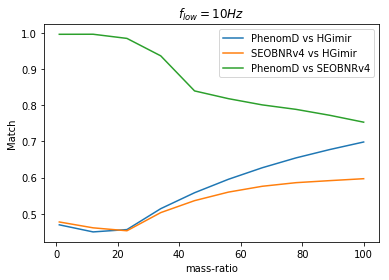

In [59]:
pylab.plot(q_list, d_vs_hgimi, label="PhenomD vs HGimir")
pylab.plot(q_list, eobv4_vs_hgimi, label="SEOBNRv4 vs HGimir")
pylab.plot(q_list, d_vs_eobv4, label="PhenomD vs SEOBNRv4")

pylab.ylabel('Match')
pylab.xlabel('mass-ratio')
pylab.legend(loc='upper right')
# pylab.xlim(0,20)
# pylab.ylim(0.99, 1)

pylab.title(r"$f_{low} = 10Hz$")
pylab.show()